In [1]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from torchvision.transforms import v2 as T

from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np


In [2]:

class CustomDataset:
    def __init__(self, folder_path, transforms=None):
        self.folder_path = folder_path
        self.transforms = transforms
        self.data_pairs = self._load_data_pairs()
        self.image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    def _load_data_pairs(self):
        image_files = []
        json_files = {}
        data_pairs = []

        # 폴더를 재귀적으로 검색하여 이미지 파일과 JSON 파일 목록을 생성
        for root, _, files in os.walk(self.folder_path):
            for file in files:
                if file.endswith((".jpg", ".jpeg", ".png")):
                    image_files.append(os.path.join(root, file))
                elif file.endswith(".json"):
                    json_files[os.path.splitext(file)[0]] = os.path.join(root, file)

        # 진행률 표시줄 추가
        for image_file_path in tqdm(image_files, desc="Matching image and JSON files"):
            # 이미지 파일 이름에서 확장자를 제외한 부분 가져오기
            image_name = os.path.splitext(os.path.basename(image_file_path))[0]
        
            # 해당 이미지 파일과 매칭되는 JSON 파일 찾기
            if image_name in json_files:
                json_file_path = json_files[image_name]
                data_pairs.append((image_file_path, json_file_path))
            else:
                print(f"JSON file not found for image: {image_file_path}")
        
        return data_pairs

    def create_detr_target(self, json_data):
        annotations = json_data['annotations']
        categories = {cat['id']: cat['name'] for cat in json_data['categories']}
        
        # 한글에서 영어로 라벨을 매핑하는 딕셔너리
        label_mapping = {'화방': "buds", '줄기': "stem", '잎': "leaf", '열매': "fruit"}

        height = 1960  # 로즈 테스트시 고정값 사용
        width = float(json_data['images'][0]['width'])

        target = {
            'boxes': [],
            'labels': [],
            'area': [],
            'iscrowd': [],
        }

        for ann in annotations:
            bbox = ann['bbox']
            obj_name = categories[ann['category_id']]
            
            # 한글 카테고리 이름을 영어로 변환
            label = label_mapping.get(obj_name, "unknown")

            # 바운딩 박스 좌표 변환 및 정규화
            x_min = bbox[1] / width
            y_min = (height-(bbox[0]+bbox[2])) / height
            box_width = bbox[3] / width
            box_height = bbox[2] / height
            
            target['boxes'].append([x_min, y_min, box_width, box_height])
            target['area'].append(ann['area'])
            target['iscrowd'].append(ann['isCrowd'])
            target['labels'].append(label)

        # 리스트를 텐서로 변환
        target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
        target['area'] = torch.tensor(target['area'], dtype=torch.float32)
        target['iscrowd'] = torch.tensor(target['iscrowd'], dtype=torch.int64)

        return target

    def preprocess_image(self, image):
        # 이미지를 모델의 입력 형식에 맞게 전처리합니다.
        # 이미지를 텐서로 변환하고 정규화합니다.
        transform = T.Compose([
            T.ToTensor(),
        ])
        image_tensor = transform(image)
        # 모델의 입력 형식에 맞게 차원을 추가합니다.
        image_tensor = image_tensor.unsqueeze(0)
        # AutoImageProcessor를 사용하여 이미지를 전처리합니다.
        images = self.image_processor(image_tensor, return_tensors="pt")
        return images
    
    def __getitem__(self, index):
        img_path, json_path = self.data_pairs[index]

        with open(json_path, 'r') as f:
            json_data = json.load(f)

        img = Image.open(img_path).convert("RGB")

        # Preprocess the image using AutoImageProcessor
        images = self.preprocess_image(img)

        target = self.create_detr_target(json_data)

        return images, target

    def __len__(self):
        return len(self.data_pairs)

In [3]:
train_path = "./dataset/train"
val_path="./dataset/val"

In [4]:
print(os.path.exists(train_path))
print(os.path.exists(val_path))

True
True


In [5]:
# 데이터셋 및 변환 정의

normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        T.ConvertImageDtype(torch.float32)
    ])

transform_train = T.Compose([
    T.RandomResizedCrop(224),  # 랜덤으로 이미지를 자르고 크기를 조정
    T.RandomHorizontalFlip(),
    normalize
])
transform_val =  T.Compose([
    normalize
])
dataset = CustomDataset(train_path, transforms=transform_train)
dataset_val = CustomDataset(val_path, transforms=transform_val)

# 학습 및 검증 데이터로더 정의
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-100:])

def collate_fn(batch):
    return tuple(zip(*batch))

loader_train = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
  
)
loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

c:\Users\User\anaconda3\envs\py3_11\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Matching image and JSON files: 100%|██████████| 80/80 [00:00<00:00, 80024.88it/s]


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def normalize_channel(channel):
    """채널을 0-1 범위로 정규화합니다."""
    channel_min = channel.min()
    channel_max = channel.max()
    return (channel - channel_min) / (channel_max - channel_min)

def plot_detection(images, target):
    fig, ax = plt.subplots(1)
    
    # 이미지 추출 및 정규화
    images = images['pixel_values'].squeeze(0).cpu().numpy()  # 배치 차원 제거 후 numpy 배열로 변환
    if images.shape[0] == 4:  # 만약 이미지가 RGBA 포맷이라면
        images = images[:3, ...]  # 알파 채널 제거하여 RGB 채널만 선택
    
    # 채널별로 독립적으로 정규화
    r_channel = normalize_channel(images[0, ...])
    g_channel = normalize_channel(images[1, ...])
    b_channel = normalize_channel(images[2, ...])
    
    # 정규화된 채널을 다시 합쳐서 3D 배열로 만듭니다.
    images_normalized = np.stack([r_channel, g_channel, b_channel], axis=0)
    
    # 이미지를 [0, 255] 범위로 변환하고 uint8 형식으로 변환
    images_normalized = (images_normalized * 255).astype(np.uint8)
    
    # 채널 순서를 변경하여 이미지 표시
    image_rgb = images_normalized.transpose(1, 2, 0)
    
    # 정규화된 채널 확인
    # print("R channel min and max values after normalization:", r_channel.min(), r_channel.max())
    # print("G channel min and max values after normalization:", g_channel.min(), g_channel.max())
    # print("B channel min and max values after normalization:", b_channel.min(), b_channel.max())

    ax.imshow(image_rgb)

    boxes = target['boxes'].cpu().numpy()
    labels = target['labels']

    height, width = images.shape[1], images.shape[2]  # 이미지의 높이와 너비 가져오기

    for box, label in zip(boxes, labels):
        x_min, y_min, box_width, box_height = box
        x_min *= width
        y_min *= height
        box_width *= width
        box_height *= height

        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # 레이블 표시
        plt.text(x_min, y_min, str(label), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


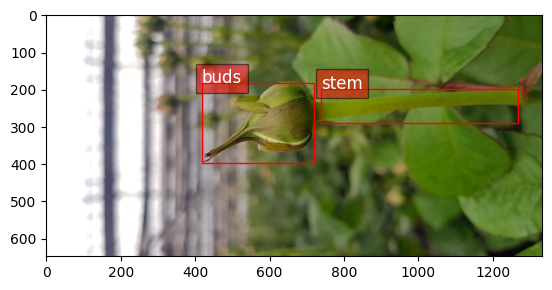

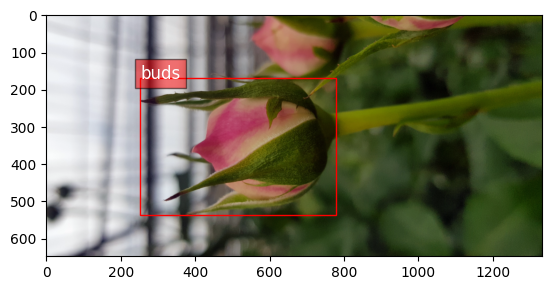

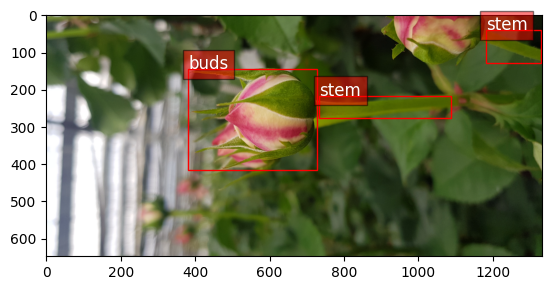

In [7]:
# 데이터셋 내용 확인 및 시각화
for i in range(len(dataset)):
    img, target = dataset[i]
    plot_detection(img, target)
    if i == 2:  # 예시로 처음 3개 항목만 확인
        break